# Discritized function

Testing

In [7]:
print("Hello, World!")

Hello, World!


In [6]:
import numpy as np
import math
from numpy import pi, sqrt
import scipy.integrate as integrate
from scipy.misc import derivative
import nbimporter # parallel_magnets_numerical_solution
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

epsilon=0.01
threed = True
DerP = 1e-5

def dBz(xp,yp,x,y,z):
    sx = x-xp
    sy = y-yp
    sz = z
    s = sx**2 + sy**2 + sz**2
    dbz = sz/s**(3/2)
    return dbz

#------------------------------------------------------------------
# New Bsquare_strip: integrates over a given x-interval [x_min, x_max]
# and over y from -b to b.
#------------------------------------------------------------------
def Bsquare_strip(x, y, z, x_min, x_max, b):
    """
    Compute the field from a magnet strip whose x-extent is [x_min, x_max]
    and whose half-thickness in y is b.
    """
    Bz, err = integrate.dblquad(
        dBz,
        -b, b,                      # yp limits: -b to b
        lambda yp: x_min,           # xp lower limit (independent of yp)
        lambda yp: x_max,           # xp upper limit
        args=(x, y, z),
        epsabs=epsilon
    )
    C = 1/(4*pi)
    return C * Bz

#------------------------------------------------------------------
# Bz_one_strip: computes the net z-field from one strip by taking the difference 
# at z ± h/2.
#------------------------------------------------------------------
def Bz_one_strip(x, y, z, x_min, x_max, b, h, mz):
    Bf = Bsquare_strip(x, y, z - h/2, x_min, x_max, b)
    Bb = Bsquare_strip(x, y, z + h/2, x_min, x_max, b)
    return mz * (Bf - Bb)

#------------------------------------------------------------------
# Bz_two_strip: computes the net field from a two-block configuration for one strip.
#------------------------------------------------------------------
def Bz_two_strip(x, y, z, x_min, x_max, b, h, zl, mz):
    Bt = Bz_one_strip(x, y, z - (zl + h/2), x_min, x_max, b, h, mz)
    Bb = Bz_one_strip(x, y, z + (zl + h/2), x_min, x_max, b, h, mz)
    return Bt + Bb

#------------------------------------------------------------------
# Bz_from_strips: Sum contributions of 16 strips along the magnet length.
#------------------------------------------------------------------
def Bz_from_strips(x, y, z, a_total, a_strip, b_list, h, zl, mz):
    """
    Compute the net Bz field at (x,y,z) by summing contributions from strips.
    
    Parameters:
      x, y, z   : Observation point.
      a_total   : Total magnet length along x (e.g., 80e-3 m).
      a_strip   : Width of each strip along x (e.g., 5e-3 m).
      b_list    : List or array of half-thickness values (in m) for each strip.
      h, zl, mz : Parameters as before.
      
    Each strip i is assumed to occupy the x-interval:
         [x_min, x_max] = [ -a_total/2 + i*a_strip,  -a_total/2 + (i+1)*a_strip ]
    The field for a strip is computed using Bz_two_strip.
    """
    N = int(a_total / a_strip)
    if len(b_list) != N:
        raise ValueError("Length of b_list must equal a_total / a_strip.")
    
    Bz_total = 0.0
    x_left = -a_total / 2.0
    for i in range(N):
        x_min = x_left + i * a_strip
        x_max = x_min + a_strip
        b_i = b_list[i]
        # Bz_two_strip computes the field for a strip assumed centered at 0.
        # Since the strip is actually located between x_min and x_max, we use the 
        # observation coordinate x directly here.
        # (The integration limits now correctly reflect the strip's physical location.)
        Bz_i = Bz_two_strip(x, y, z, x_min, x_max, b_i, h, zl, mz)
        Bz_total += Bz_i
    return Bz_total

def gradBz_from_strips(x, y, z, a_total, a_strip, b_list, h, zl, mz):
    def fx(x):
        return Bz_from_strips(x, y, z, a_total, a_strip, b_list, h, zl, mz)
    def fy(y):
        return Bz_from_strips(x, y, z, a_total, a_strip, b_list, h, zl, mz)
    def fz(z):
        return Bz_from_strips(x, y, z, a_total, a_strip, b_list, h, zl, mz)
    dBdx = derivative(fx, x, dx=DerP)
    if threed:
        dBdy = derivative(fy, y, dx=DerP)
    else:
        dBdy = 0
    dBdz = derivative(fz, z, dx=DerP)
    return (dBdx,dBdy,dBdz)

In [2]:
def plot_magnet_with_strips(a_total, a_strip, b_list):
    # X positions for strip centers
    strip_centers = np.linspace(-a_total/2 + a_strip/2, a_total/2 - a_strip/2, len(b_list))

    # Create figure
    plt.figure(figsize=(8, 8))
    
    # Loop through each strip and plot it
    for x, b in zip(strip_centers, b_list):
        plt.fill_between([x - a_strip/2, x + a_strip/2], -b, b, color='grey', alpha=0.7)
        plt.plot([x - a_strip/2, x + a_strip/2, x + a_strip/2, x - a_strip/2, x - a_strip/2],
                 [-b, -b, b, b, -b], color='blue', linewidth=2)

    # Formatting the plot
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.title("Magnet Shape with Strips")
    plt.axis("square")
    plt.grid(True)

    # Set axis limits
    plt.xlim(-a_total/2*1.2, a_total/2*1.2)
    plt.ylim(-a_total/2*1.2, a_total/2*1.2)

    # Show plot
    plt.show()
    
def plot_Bz_and_grad_vs_z(z_range, a_total, a_strip, b_list, h, zl, mz):
    """
    Given an array of z–values (in meters), this function:
      - Computes Bz vs. z using Bz_two,
      - Finds and prints the extrema,
      - Plots Bz vs. z,
      - Computes the gradient using gradBz_two,
      - Finds and prints its extrema,
      - And plots the gradient vs. z.
    
    Assumes global parameters: a, b, h, zl, mz and functions Bz_two, gradBz_two are defined.
    """
    # Set x and y to 0 for the evaluation.
    x_val = 0
    y_val = 0
    
    # Calculate magnetic field strength for each z.
    B_Z_values = np.array([Bz_from_strips(x_val, y_val, zi, a_total, a_strip, b_list, h, zl, mz) for zi in z_range])
    
    # Find minima and maxima for Bz.
    min_index = np.argmin(B_Z_values)   # index of minimum value
    max_index_begin = 0                  # assume left edge is maximum (if desired)
    max_index_end = -1                   # assume right edge is maximum
    # (Adjust these assumptions as needed.)
    
    min_value = B_Z_values[min_index]
    max_value_begin = B_Z_values[max_index_begin]
    max_value_end = B_Z_values[max_index_end]
    
    min_position = z_range[min_index] * 1e3      # convert to mm
    max_position_begin = z_range[max_index_begin] * 1e3
    max_position_end = z_range[max_index_end] * 1e3
    
    print(f"Magnetic Field Strength:")
    print(f"  Minimum value: {min_value:.6f} T at Z = {min_position:.2f} mm")
    print(f"  Maximum value (beginning): {max_value_begin:.6f} T at Z = {max_position_begin:.2f} mm")
    print(f"  Maximum value (end): {max_value_end:.6f} T at Z = {max_position_end:.2f} mm")
    
    # Plot Bz vs. z.
    plt.figure(figsize=(10, 8))
    plt.plot(z_range * 1e3, B_Z_values, label="Magnetic Field Strength $B_Z$", color="blue")
    plt.scatter([min_position], [min_value], color="red", label=f"Min: {min_value:.6f} T", zorder=5)
    plt.scatter([max_position_begin], [max_value_begin], color="green", label=f"Max (beginning): {max_value_begin:.6f} T", zorder=5)
    plt.scatter([max_position_end], [max_value_end], color="orange", label=f"Max (end): {max_value_end:.6f} T", zorder=5)
    plt.xlabel("Z Position (mm)")
    plt.ylabel("Magnetic Field Strength $B_Z$ (T)")
    plt.title("Magnetic Field Strength $B_Z$ vs Z Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()
    
     # Calculate magnetic field gradient for each z.
    gradB_tst = np.array([gradBz_from_strips(x_val, y_val, zi, a_total, a_strip, b_list, h, zl, mz) for zi in z_range])
    # Extract the third component (dBz/dz).
    dB_Z_values = gradB_tst[:, 2]
    
    # Find minima and maxima for the gradient.
    min_index_grad = np.argmin(dB_Z_values)
    max_index_grad = np.argmax(dB_Z_values)
    
    min_grad_value = dB_Z_values[min_index_grad]
    max_grad_value = dB_Z_values[max_index_grad]
    
    min_grad_position = z_range[min_index_grad] * 1e3
    max_grad_position = z_range[max_index_grad] * 1e3
    
    print(f"Magnetic Field Gradient:")
    print(f"  Minimum gradient: {min_grad_value:.6f} T/m at Z = {min_grad_position:.2f} mm")
    print(f"  Maximum gradient: {max_grad_value:.6f} T/m at Z = {max_grad_position:.2f} mm")
    
    # Plot the gradient vs. z.
    plt.figure(figsize=(10, 8))
    plt.plot(z_range * 1e3, dB_Z_values, label="Magnetic Field Gradient $dB_Z/dZ$", color="blue")
    plt.scatter([min_grad_position], [min_grad_value], color="red", label=f"Min: {min_grad_value:.6f} T/m", zorder=5)
    plt.scatter([max_grad_position], [max_grad_value], color="green", label=f"Max: {max_grad_value:.6f} T/m", zorder=5)
    plt.scatter([0], [0], color="black", marker='x', label="Gradient Zero at (0,0)", zorder=5)
    plt.xlabel("Z Position (mm)")
    plt.ylabel("Magnetic Field Gradient $dB_Z/dZ$ (T/m)")
    plt.title("Magnetic Field Gradient $dB_Z/dZ$ vs Z Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()
    
def plot_Bz_and_grad_vs_x(x_range, a_total, a_strip, b_list, h, zl, mz):
    """
    Given an array x_range (in meters), this function:
      - Calculates Bz (using Bz_two) at (x, y=0, z=0)
      - Finds and prints the extrema for Bz versus x
      - Plots Bz versus x (x in mm)
      - Calculates the magnetic field gradient using gradBz_two
      - Finds and prints the extrema for the gradient
      - Plots the gradient (dBz/dx) versus x (x in mm)
    
    Assumes that the global variables and functions (a, b, h, zl, mz, Bz_two, gradBz_two) are defined.
    """
    y_val = 0
    z_val = 0
    
    # Calculate magnetic field strength for each x
    B_values = np.array([Bz_from_strips(xi, y_val, z_val, a_total, a_strip, b_list, h, zl, mz) for xi in x_range])
    
    # Find extrema for Bz: assume maximum is in the middle, and minima at left and right edges.
    max_index = np.argmax(B_values)
    min_index_begin = 0
    min_index_end = -1
    
    max_value = B_values[max_index]
    min_value_begin = B_values[min_index_begin]
    min_value_end = B_values[min_index_end]
    
    max_position = x_range[max_index] * 1e3       # convert to mm
    min_position_begin = x_range[min_index_begin] * 1e3
    min_position_end = x_range[min_index_end] * 1e3
    
    # Print the extrema details for Bz
    print(f"Magnetic Field Strength:")
    print(f"  Maximum value: {max_value:.6f} T at X = {max_position:.2f} mm")
    print(f"  Minimum value (left): {min_value_begin:.6f} T at X = {min_position_begin:.2f} mm")
    print(f"  Minimum value (right): {min_value_end:.6f} T at X = {min_position_end:.2f} mm")
    
    # Plot Bz versus x
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8))
    plt.plot(x_range * 1e3, B_values, label="Magnetic Field Strength $B_Z$", color="blue")
    plt.scatter([max_position], [max_value], color="green", label=f"Max: {max_value:.6f} T", zorder=5)
    plt.scatter([min_position_begin], [min_value_begin], color="red", label=f"Min (left): {min_value_begin:.6f} T", zorder=5)
    plt.scatter([min_position_end], [min_value_end], color="orange", label=f"Min (right): {min_value_end:.6f} T", zorder=5)
    plt.xlabel("X Position (mm)")
    plt.ylabel("Magnetic Field Strength $B_Z$ (T)")
    plt.title("Magnetic Field Strength $B_Z$ vs X Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()
    
    # Calculate magnetic field gradient for each x using gradBz_two.
    # gradBz_two returns a tuple (dBdx, dBdy, dBdz); we extract the first component (dBz/dx).
    gradB_tst = np.array([gradBz_from_strips(xi, y_val, z_val, a_total, a_strip, b_list, h, zl, mz) for xi in x_range])
    dB_Z_values = gradB_tst[:, 0]

    # Find minimum and maximum
    min_index = np.argmin(dB_Z_values)  # Index of minimum value
    max_index = np.argmax(dB_Z_values)  # Index of maximum value

    # Values and positions
    min_value = dB_Z_values[min_index]
    max_value = dB_Z_values[max_index]
    min_position = x_range[min_index] * 1e3  # Convert to mm
    max_position = x_range[max_index] * 1e3  # Convert to mm

    # Print the extrema details
    print(f"Minimum value: {min_value:.6f} T/m at X = {min_position:.2f} mm")
    print(f"Maximum value: {max_value:.6f} T/m at X = {max_position:.2f} mm")

    # Plot the results
    plt.figure(figsize=(10, 8))  # Increased figure size
    plt.plot(x_range * 1e3, dB_Z_values, label="Magnetic Field Gradient $dB_Z/dX$", color="blue")
    plt.scatter([min_position], [min_value], color="red", label=f"Min: {min_value:.6f} T/m", zorder=5)
    plt.scatter([max_position], [max_value], color="green", label=f"Max: {max_value:.6f} T/m", zorder=5)
    plt.scatter([0], [0], color="black", marker='x', label="Gradient Zero at (0,0)", zorder=5)
    plt.xlabel("X Position (mm)")
    plt.ylabel("Magnetic Field Gradient $dB_Z/dX$ (T/m)")
    plt.title("Magnetic Field Gradient $dB_Z/dX$ vs X Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()

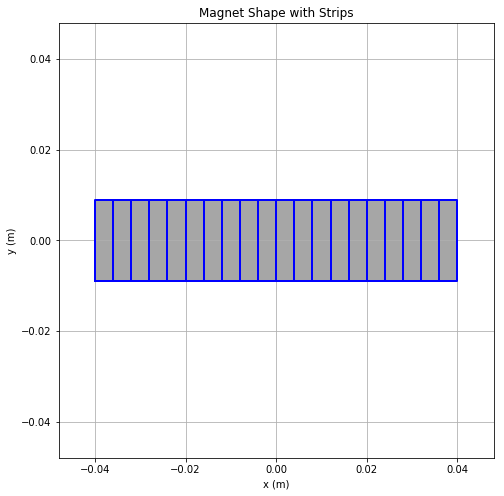

In [3]:
# Magnet parameters:
a_total = 80e-3   # total magnet length: 80 mm
a_strip = 4e-3    # each strip is 5 mm wide -> 16 strips total

# For each strip, specify its half-thickness in y.
# For example, you might want the center strips to be narrower and the edge strips wider:
b_list = [9e-3, 9e-3, 9e-3, 9e-3,   # left edge: wider
          9e-3, 9e-3, 9e-3, 9e-3,  # next four: narrower
          9e-3, 9e-3, 9e-3, 9e-3,   # next four: narrower
          9e-3, 9e-3, 9e-3, 9e-3,
          9e-3, 9e-3, 9e-3, 9e-3]   # right edge: wider

h = 5e-3         # block thickness (5 mm)
zl = 20e-3       # vertical offset parameter (20 mm)
mz = 1.19        # magnetization factor

#Plot magnet
plot_magnet_with_strips(a_total, a_strip, b_list)

Magnetic Field Strength:
  Minimum value: 0.064007 T at Z = 0.00 mm
  Maximum value (beginning): 0.196006 T at Z = -19.00 mm
  Maximum value (end): 0.196006 T at Z = 19.00 mm


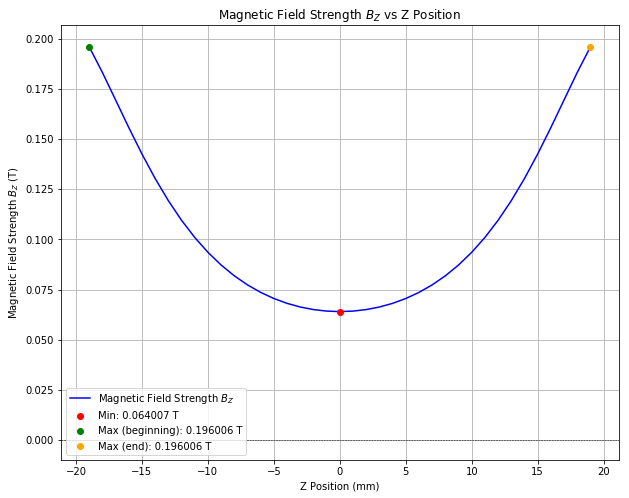

Magnetic Field Gradient:
  Minimum gradient: -13.858596 T/m at Z = -17.00 mm
  Maximum gradient: 13.858596 T/m at Z = 17.00 mm


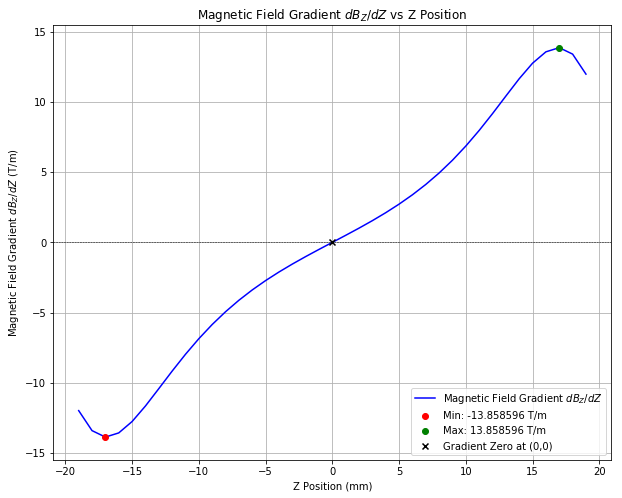

In [4]:
# Plot Bz and dBz/dz against the z-position
z_range = np.arange(-19e-3, 20e-3, 1e-3)  # from -19 mm to 20 mm
plot_Bz_and_grad_vs_z(z_range, a_total, a_strip, b_list, h, zl, mz)

Magnetic Field Strength:
  Maximum value: 0.064007 T at X = 0.00 mm
  Minimum value (left): 0.030395 T at X = -40.00 mm
  Minimum value (right): 0.030395 T at X = 40.00 mm


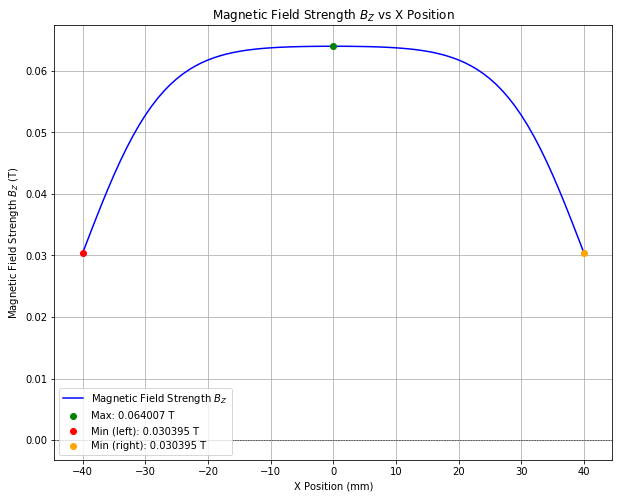

Minimum value: -2.662996 T/m at X = 40.00 mm
Maximum value: 2.662996 T/m at X = -40.00 mm


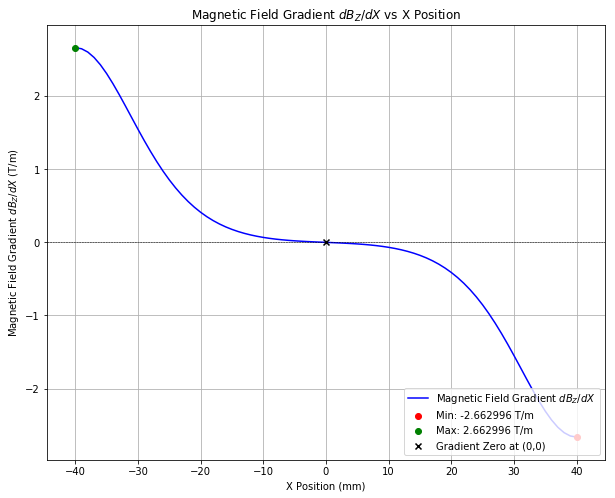

In [5]:
# Plot Bz and dBz/dx against the x-position
x_range = np.arange(-40e-3, 41e-3, 1e-3)  # x from -40 mm to 40 mm
plot_Bz_and_grad_vs_x(x_range, a_total, a_strip, b_list, h, zl, mz)

# Width and Height

In [9]:
def Bz_from_strips_height(x, y, z, a_total, a_strip, b_list, h_list, zl, mz):
    """
    Compute the net Bz field at (x,y,z) by summing contributions from strips,
    where each strip has its own half-thickness (b) and its own h value.
    
    Parameters:
      x, y, z   : Observation point.
      a_total   : Total magnet length along x (e.g., 80e-3 m).
      a_strip   : Width of each strip along x (e.g., 5e-3 m).
      b_list    : List or array of half-thickness values (in m) for each strip.
      h_list    : List or array of h values (in m) for each strip.
      zl, mz    : Other parameters as before.
      
    Each strip i is assumed to occupy the x-interval:
         [x_min, x_max] = [ -a_total/2 + i*a_strip,  -a_total/2 + (i+1)*a_strip ]
    The field for a strip is computed using Bz_two_strip, using the corresponding b and h.
    """
    N = int(a_total / a_strip)
    if len(b_list) != N or len(h_list) != N:
        raise ValueError("Length of b_list and h_list must equal a_total / a_strip.")
    
    Bz_total = 0.0
    x_left = -a_total / 2.0
    for i in range(N):
        x_min = x_left + i * a_strip
        x_max = x_min + a_strip
        b_i = b_list[i]
        h_i = h_list[i]
        # Bz_two_strip computes the field for a strip with x-interval [x_min, x_max],
        # half-thickness b_i, and thickness parameter h_i.
        Bz_i = Bz_two_strip(x, y, z, x_min, x_max, b_i, h_i, zl, mz)
        Bz_total += Bz_i
    return Bz_total

def gradBz_from_strips_height(x, y, z, a_total, a_strip, b_list, h_list, zl, mz):
    def fx(x):
        return Bz_from_strips_height(x, y, z, a_total, a_strip, b_list, h_list, zl, mz)
    def fy(y):
        return Bz_from_strips_height(x, y, z, a_total, a_strip, b_list, h_list, zl, mz)
    def fz(z):
        return Bz_from_strips_height(x, y, z, a_total, a_strip, b_list, h_list, zl, mz)
    dBdx = derivative(fx, x, dx=DerP)
    if threed:
        dBdy = derivative(fy, y, dx=DerP)
    else:
        dBdy = 0
    dBdz = derivative(fz, z, dx=DerP)
    return (dBdx,dBdy,dBdz)

In [10]:
def plot_Bz_and_grad_vs_z_height(z_range, a_total, a_strip, b_list, h_list, zl, mz):
    """
    Given an array of z–values (in meters), this function:
      - Computes Bz vs. z using Bz_two,
      - Finds and prints the extrema,
      - Plots Bz vs. z,
      - Computes the gradient using gradBz_two,
      - Finds and prints its extrema,
      - And plots the gradient vs. z.
    
    Assumes global parameters: a, b, h, zl, mz and functions Bz_two, gradBz_two are defined.
    """
    # Set x and y to 0 for the evaluation.
    x_val = 0
    y_val = 0
    
    # Calculate magnetic field strength for each z.
    B_Z_values = np.array([Bz_from_strips_height(x_val, y_val, zi, a_total, a_strip, b_list, h_list, zl, mz) for zi in z_range])
    
    # Find minima and maxima for Bz.
    min_index = np.argmin(B_Z_values)   # index of minimum value
    max_index_begin = 0                  # assume left edge is maximum (if desired)
    max_index_end = -1                   # assume right edge is maximum
    # (Adjust these assumptions as needed.)
    
    min_value = B_Z_values[min_index]
    max_value_begin = B_Z_values[max_index_begin]
    max_value_end = B_Z_values[max_index_end]
    
    min_position = z_range[min_index] * 1e3      # convert to mm
    max_position_begin = z_range[max_index_begin] * 1e3
    max_position_end = z_range[max_index_end] * 1e3
    
    print(f"Magnetic Field Strength:")
    print(f"  Minimum value: {min_value:.6f} T at Z = {min_position:.2f} mm")
    print(f"  Maximum value (beginning): {max_value_begin:.6f} T at Z = {max_position_begin:.2f} mm")
    print(f"  Maximum value (end): {max_value_end:.6f} T at Z = {max_position_end:.2f} mm")
    
    # Plot Bz vs. z.
    plt.figure(figsize=(10, 8))
    plt.plot(z_range * 1e3, B_Z_values, label="Magnetic Field Strength $B_Z$", color="blue")
    plt.scatter([min_position], [min_value], color="red", label=f"Min: {min_value:.6f} T", zorder=5)
    plt.scatter([max_position_begin], [max_value_begin], color="green", label=f"Max (beginning): {max_value_begin:.6f} T", zorder=5)
    plt.scatter([max_position_end], [max_value_end], color="orange", label=f"Max (end): {max_value_end:.6f} T", zorder=5)
    plt.xlabel("Z Position (mm)")
    plt.ylabel("Magnetic Field Strength $B_Z$ (T)")
    plt.title("Magnetic Field Strength $B_Z$ vs Z Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()
    
     # Calculate magnetic field gradient for each z.
    gradB_tst = np.array([gradBz_from_strips_height(x_val, y_val, zi, a_total, a_strip, b_list, h_list, zl, mz) for zi in z_range])
    # Extract the third component (dBz/dz).
    dB_Z_values = gradB_tst[:, 2]
    
    # Find minima and maxima for the gradient.
    min_index_grad = np.argmin(dB_Z_values)
    max_index_grad = np.argmax(dB_Z_values)
    
    min_grad_value = dB_Z_values[min_index_grad]
    max_grad_value = dB_Z_values[max_index_grad]
    
    min_grad_position = z_range[min_index_grad] * 1e3
    max_grad_position = z_range[max_index_grad] * 1e3
    
    print(f"Magnetic Field Gradient:")
    print(f"  Minimum gradient: {min_grad_value:.6f} T/m at Z = {min_grad_position:.2f} mm")
    print(f"  Maximum gradient: {max_grad_value:.6f} T/m at Z = {max_grad_position:.2f} mm")
    
    # Plot the gradient vs. z.
    plt.figure(figsize=(10, 8))
    plt.plot(z_range * 1e3, dB_Z_values, label="Magnetic Field Gradient $dB_Z/dZ$", color="blue")
    plt.scatter([min_grad_position], [min_grad_value], color="red", label=f"Min: {min_grad_value:.6f} T/m", zorder=5)
    plt.scatter([max_grad_position], [max_grad_value], color="green", label=f"Max: {max_grad_value:.6f} T/m", zorder=5)
    plt.scatter([0], [0], color="black", marker='x', label="Gradient Zero at (0,0)", zorder=5)
    plt.xlabel("Z Position (mm)")
    plt.ylabel("Magnetic Field Gradient $dB_Z/dZ$ (T/m)")
    plt.title("Magnetic Field Gradient $dB_Z/dZ$ vs Z Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()
    
def plot_Bz_and_grad_vs_x_height(x_range, a_total, a_strip, b_list, h_list, zl, mz):
    """
    Given an array x_range (in meters), this function:
      - Calculates Bz (using Bz_two) at (x, y=0, z=0)
      - Finds and prints the extrema for Bz versus x
      - Plots Bz versus x (x in mm)
      - Calculates the magnetic field gradient using gradBz_two
      - Finds and prints the extrema for the gradient
      - Plots the gradient (dBz/dx) versus x (x in mm)
    
    Assumes that the global variables and functions (a, b, h, zl, mz, Bz_two, gradBz_two) are defined.
    """
    y_val = 0
    z_val = 0
    
    # Calculate magnetic field strength for each x
    B_values = np.array([Bz_from_strips_height(xi, y_val, z_val, a_total, a_strip, b_list, h_list, zl, mz) for xi in x_range])
    
    # Find extrema for Bz: assume maximum is in the middle, and minima at left and right edges.
    max_index = np.argmax(B_values)
    min_index_begin = 0
    min_index_end = -1
    
    max_value = B_values[max_index]
    min_value_begin = B_values[min_index_begin]
    min_value_end = B_values[min_index_end]
    
    max_position = x_range[max_index] * 1e3       # convert to mm
    min_position_begin = x_range[min_index_begin] * 1e3
    min_position_end = x_range[min_index_end] * 1e3
    
    # Print the extrema details for Bz
    print(f"Magnetic Field Strength:")
    print(f"  Maximum value: {max_value:.6f} T at X = {max_position:.2f} mm")
    print(f"  Minimum value (left): {min_value_begin:.6f} T at X = {min_position_begin:.2f} mm")
    print(f"  Minimum value (right): {min_value_end:.6f} T at X = {min_position_end:.2f} mm")
    
    # Plot Bz versus x
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8))
    plt.plot(x_range * 1e3, B_values, label="Magnetic Field Strength $B_Z$", color="blue")
    plt.scatter([max_position], [max_value], color="green", label=f"Max: {max_value:.6f} T", zorder=5)
    plt.scatter([min_position_begin], [min_value_begin], color="red", label=f"Min (left): {min_value_begin:.6f} T", zorder=5)
    plt.scatter([min_position_end], [min_value_end], color="orange", label=f"Min (right): {min_value_end:.6f} T", zorder=5)
    plt.xlabel("X Position (mm)")
    plt.ylabel("Magnetic Field Strength $B_Z$ (T)")
    plt.title("Magnetic Field Strength $B_Z$ vs X Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()
    
    # Calculate magnetic field gradient for each x using gradBz_two.
    # gradBz_two returns a tuple (dBdx, dBdy, dBdz); we extract the first component (dBz/dx).
    gradB_tst = np.array([gradBz_from_strips_height(xi, y_val, z_val, a_total, a_strip, b_list, h_list, zl, mz) for xi in x_range])
    dB_Z_values = gradB_tst[:, 0]

    # Find minimum and maximum
    min_index = np.argmin(dB_Z_values)  # Index of minimum value
    max_index = np.argmax(dB_Z_values)  # Index of maximum value

    # Values and positions
    min_value = dB_Z_values[min_index]
    max_value = dB_Z_values[max_index]
    min_position = x_range[min_index] * 1e3  # Convert to mm
    max_position = x_range[max_index] * 1e3  # Convert to mm

    # Print the extrema details
    print(f"Minimum value: {min_value:.6f} T/m at X = {min_position:.2f} mm")
    print(f"Maximum value: {max_value:.6f} T/m at X = {max_position:.2f} mm")

    # Plot the results
    plt.figure(figsize=(10, 8))  # Increased figure size
    plt.plot(x_range * 1e3, dB_Z_values, label="Magnetic Field Gradient $dB_Z/dX$", color="blue")
    plt.scatter([min_position], [min_value], color="red", label=f"Min: {min_value:.6f} T/m", zorder=5)
    plt.scatter([max_position], [max_value], color="green", label=f"Max: {max_value:.6f} T/m", zorder=5)
    plt.scatter([0], [0], color="black", marker='x', label="Gradient Zero at (0,0)", zorder=5)
    plt.xlabel("X Position (mm)")
    plt.ylabel("Magnetic Field Gradient $dB_Z/dX$ (T/m)")
    plt.title("Magnetic Field Gradient $dB_Z/dX$ vs X Position")
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()

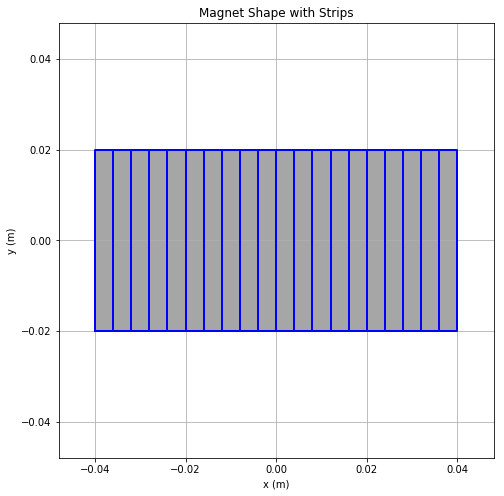

In [11]:
# Magnet parameters:
a_total = 80e-3   # total magnet length: 80 mm
a_strip = 4e-3    # each strip is 5 mm wide -> 16 strips total

# For each strip, specify its half-thickness in y.
# For example, you might want the center strips to be narrower and the edge strips wider:
b_list = [20e-3, 20e-3, 20e-3, 20e-3,   # left edge: wider
          20e-3, 20e-3, 20e-3, 20e-3,  # next four: narrower
          20e-3, 20e-3, 20e-3, 20e-3,  # next four: narrower
          20e-3, 20e-3, 20e-3, 20e-3,
          20e-3, 20e-3, 20e-3, 20e-3]   # right edge: wider

h_list = [2e-3, 1e-3, 1e-3, 1e-3,   # left edge: higher
          1e-3, 1e-3, 1e-3, 1e-3,  # next four: lower
          1e-3, 1e-3, 1e-3, 1e-3,   # next four: lower
          1e-3, 1e-3, 1e-3, 1e-3,
          1e-3, 1e-3, 1e-3, 2e-3]   # right edge: higher
zl = 20e-3       # vertical offset parameter (20 mm)
mz = 1.19        # magnetization factor

#Plot magnet
plot_magnet_with_strips(a_total, a_strip, b_list)

Magnetic Field Strength:
  Minimum value: 0.020912 T at Z = 0.00 mm
  Maximum value (beginning): 0.024864 T at Z = -19.00 mm
  Maximum value (end): 0.024864 T at Z = 19.00 mm


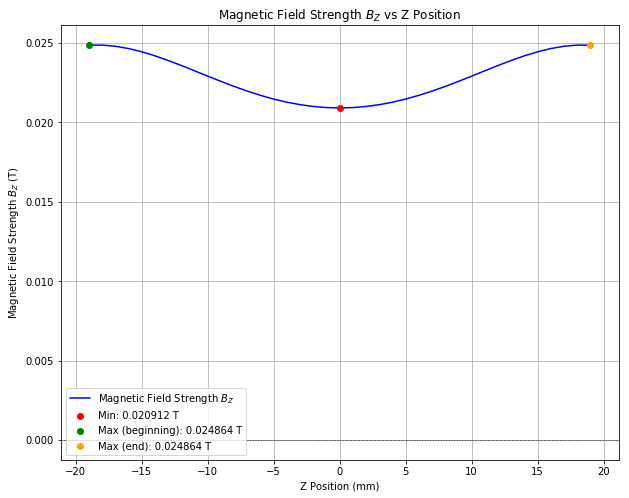

Magnetic Field Gradient:
  Minimum gradient: -0.336303 T/m at Z = -11.00 mm
  Maximum gradient: 0.336303 T/m at Z = 11.00 mm


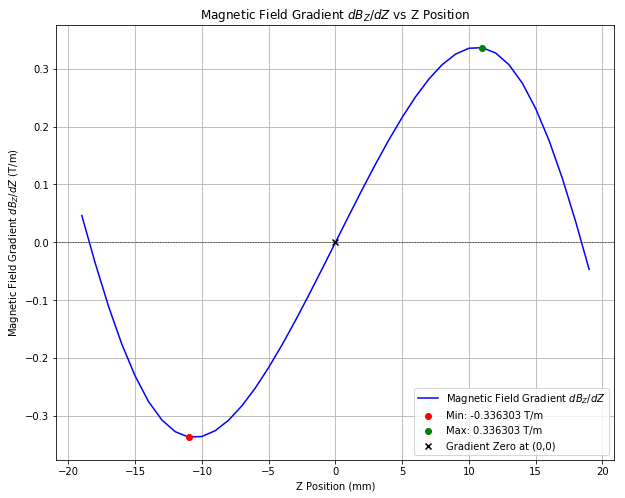

In [12]:
# Plot Bz and dBz/dz against the z-position
z_range = np.arange(-19e-3, 20e-3, 1e-3)  # from -19 mm to 20 mm
plot_Bz_and_grad_vs_z_height(z_range, a_total, a_strip, b_list, h_list, zl, mz)

Magnetic Field Strength:
  Maximum value: 0.021176 T at X = -20.00 mm
  Minimum value (left): 0.013024 T at X = -40.00 mm
  Minimum value (right): 0.013024 T at X = 40.00 mm


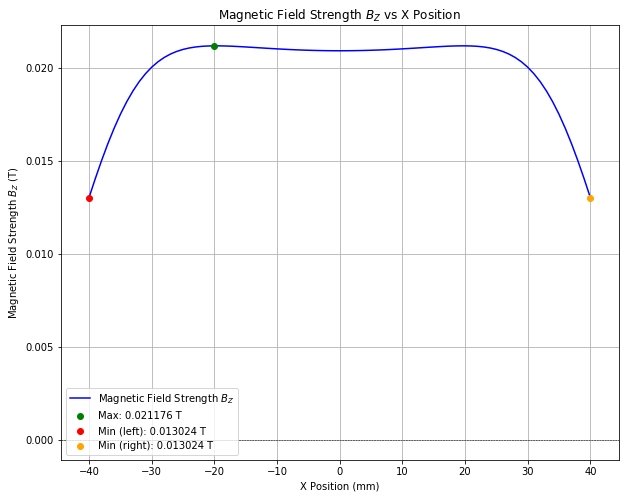

Minimum value: -1.039324 T/m at X = 40.00 mm
Maximum value: 1.039324 T/m at X = -40.00 mm


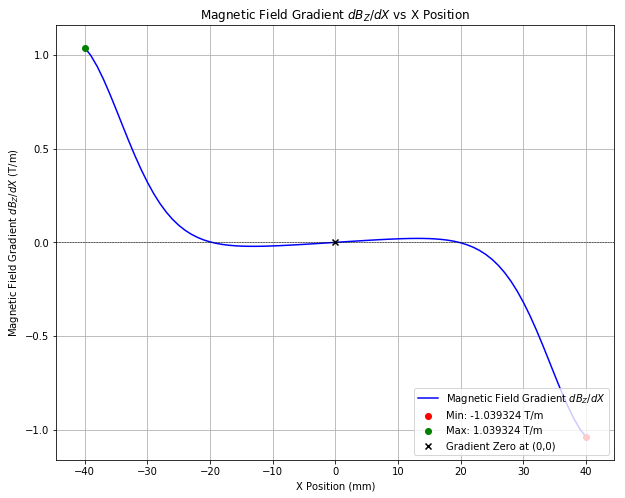

In [13]:
# Plot Bz and dBz/dx against the x-position
x_range = np.arange(-40e-3, 41e-3, 1e-3)  # x from -40 mm to 40 mm
plot_Bz_and_grad_vs_x_height(x_range, a_total, a_strip, b_list, h_list, zl, mz)

# Width, distance, height

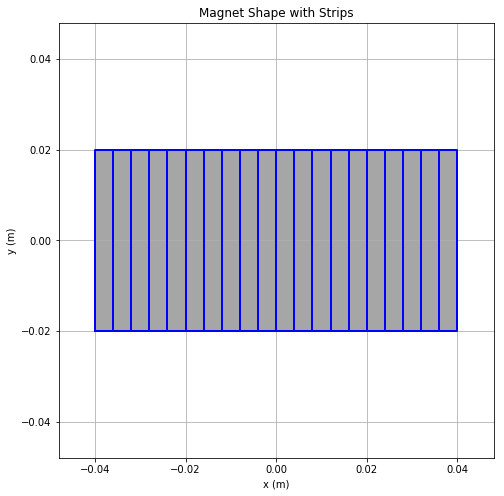

Magnetic Field Strength:
  Maximum value: 0.024891 T at X = 13.00 mm
  Minimum value (left): 0.019941 T at X = -40.00 mm
  Minimum value (right): 0.019941 T at X = 40.00 mm


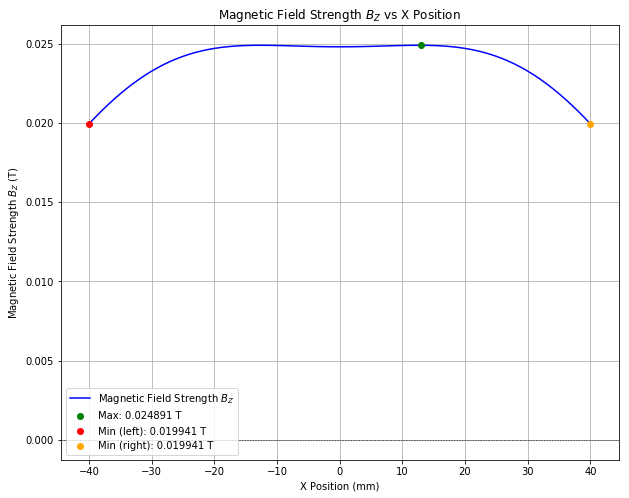

Minimum value: -0.420751 T/m at X = 40.00 mm
Maximum value: 0.420751 T/m at X = -40.00 mm


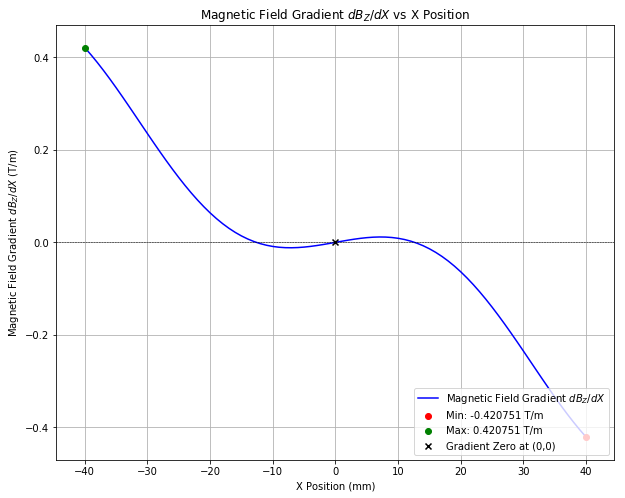

In [14]:
# Magnet parameters:
a_total = 80e-3   # total magnet length: 80 mm
a_strip = 4e-3    # each strip is 5 mm wide -> 16 strips total

# For each strip, specify its half-thickness in y.
# For example, you might want the center strips to be narrower and the edge strips wider:
b_list = [20e-3, 20e-3, 20e-3, 20e-3,   # left edge: wider
          20e-3, 20e-3, 20e-3, 20e-3,  # next four: narrower
          20e-3, 20e-3, 20e-3, 20e-3,  # next four: narrower
          20e-3, 20e-3, 20e-3, 20e-3,
          20e-3, 20e-3, 20e-3, 20e-3]   # right edge: wider

h_list = [30e-3, 20e-3, 10e-3, 3e-3,   # left edge: higher
          3e-3, 3e-3, 3e-3, 3e-3,  # next four: lower
          3e-3, 3e-3, 3e-3, 3e-3,   # next four: lower
          3e-3, 3e-3, 3e-3, 3e-3,
          3e-3, 10e-3, 20e-3, 30e-3]   # right edge: higher
zl = 50e-3       # vertical offset parameter (20 mm)
mz = 1.19        # magnetization factor

#Plot magnet
plot_magnet_with_strips(a_total, a_strip, b_list)

# Plot Bz and dBz/dx against the x-position
x_range = np.arange(-40e-3, 41e-3, 1e-3)  # x from -40 mm to 40 mm
plot_Bz_and_grad_vs_x_height(x_range, a_total, a_strip, b_list, h_list, zl, mz)

# Test code

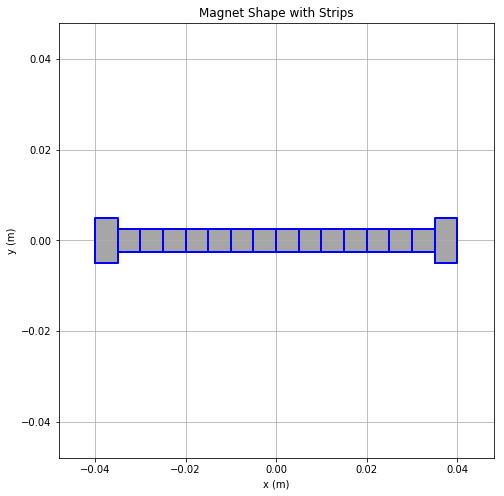

Net Bz field from 16 strips = 0.0028107641619933826


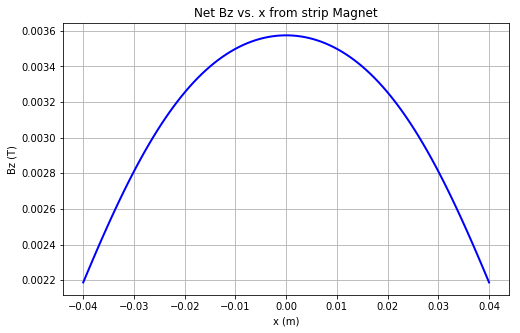

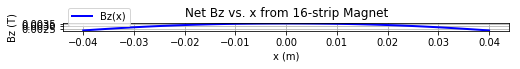

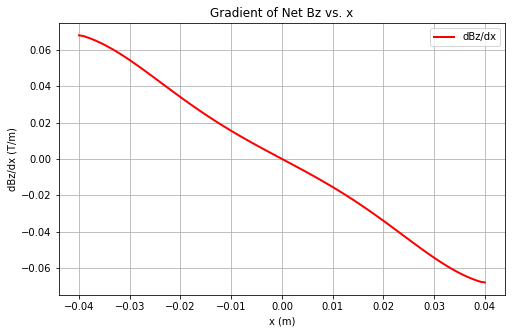

In [15]:
a_total = 80e-3   # total magnet length: 80 mm
a_strip = 5e-3
b_list = [5e-3, 2.5e-3, 2.5e-3, 2.5e-3,   # left edge: wider
          2.5e-3, 2.5e-3, 2.5e-3, 2.5e-3,  # next four: narrower
          2.5e-3, 2.5e-3, 2.5e-3, 2.5e-3,   # next four: narrower
          2.5e-3, 2.5e-3, 2.5e-3, 5e-3] 
#Plot magnet
plot_magnet_with_strips(a_total, a_strip, b_list)

# Choose an observation point, for example (x=30e-3, y=0, z=0)
x_obs = 30e-3
y_obs = 0
z_obs = 0

Bz_net = Bz_from_strips(x_obs, y_obs, z_obs, a_total, a_strip, b_list, h, zl, mz)
print("Net Bz field from 16 strips =", Bz_net)

y_obs = 0
z_obs = 0

#------------------------------------------------------------------
# Optionally, plot the net field along x (with y=0, z=0)
#------------------------------------------------------------------
x_vals = np.linspace(-a_total/2, a_total/2, 100)
Bz_vals = [Bz_from_strips(xi, y_obs, z_obs, a_total, a_strip, b_list, h, zl, mz)
           for xi in x_vals]

plt.figure(figsize=(8,5))
plt.plot(x_vals, Bz_vals, 'b-', linewidth=2)
plt.xlabel("x (m)")
plt.ylabel("Bz (T)")
plt.title("Net Bz vs. x from strip Magnet")
plt.grid(True)
plt.show()

dBz_dx = np.gradient(Bz_vals, x_vals)

# Plot the original Bz vs. x graph.
plt.figure(figsize=(8,5))
plt.plot(x_vals, Bz_vals, 'b-', linewidth=2, label='Bz(x)')
plt.xlabel("x (m)")
plt.ylabel("Bz (T)")
plt.title("Net Bz vs. x from 16-strip Magnet")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

# Now plot the gradient.
plt.figure(figsize=(8,5))
plt.plot(x_vals, dBz_dx, 'r-', linewidth=2, label='dBz/dx')
plt.xlabel("x (m)")
plt.ylabel("dBz/dx (T/m)")
plt.title("Gradient of Net Bz vs. x")
plt.grid(True)
plt.legend()
plt.show()